In [ ]:
import os
import numpy as np
from scipy import stats

import torch

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert
from source.utils.metrics import auroc, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

In [2]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50", "regnet", "efficientnet", "efficientnet_mcdropout"][2]

pas = ["old", "woman", "white"]
pa = 0 # 0, 1, 2

In [3]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

p_a_fair = a_fair_t.float().mean().item() * 100
p_y_fair = y_fair_t.float().mean().item() * 100

# patients general 65401
# patients with race 58010
24638 24638


In [4]:
# load probits
fair_probits, val_probits = list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

    # don't do fairness ensemble on medical imaging - use this split as test dataset
    fp = torch.load(os.path.join(path, f"fair_probits.pt"))
    #fp = 1 - fp
    fair_probits.append(fp)
    vp = torch.load(os.path.join(path, f"val_probits.pt"))
    #vp = 1 - vp
    val_probits.append(vp)

In [5]:
# calculate accuracies and fairness measures
fair_aurocs, val_aurocs = list(), list()
fair_spds, val_spds = list(), list()
fair_eods, val_eods = list(), list()
fair_aods, val_aods = list(), list()

for m in range(len(method_seeds)):
    fair_aurocs.append([auroc(p[:, 1], y_fair_t) for p in fair_probits[m]])
    val_aurocs.append([auroc(p[:, 1], y_val_t) for p in val_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])

    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

In [6]:
fair_m_aurocs = list()
fair_m_spds = list()
fair_m_eods = list()
fair_m_aods = list()

for m in range(len(method_seeds)):
    fair_m_aurocs.append(auroc(torch.mean(fair_probits[m], dim=0)[:, 1], y_fair_t))

    fair_m_spds.append(spd(torch.mean(fair_probits[m], dim=0).argmax(dim=1), a_fair_t))
    
    fair_m_eods.append(eod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

    fair_m_aods.append(aod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

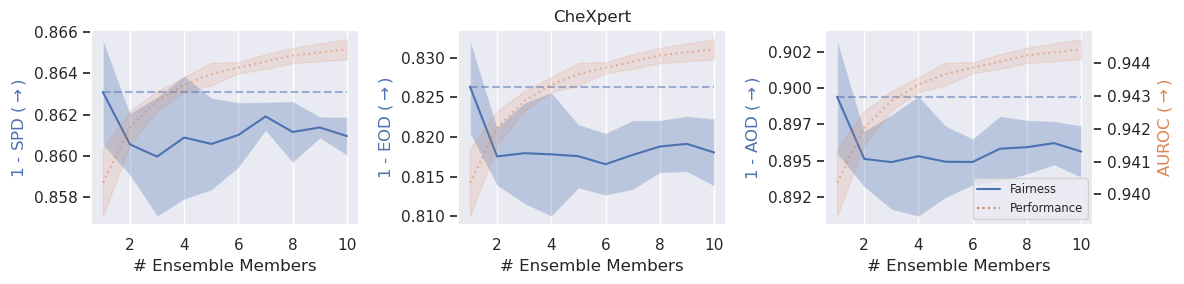

In [7]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

fair_fm_aurocs, fair_fm_spds, fair_fm_eods, fair_fm_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):

    fair_fm_aurocs_, fair_fm_spds_, fair_fm_eods_, fair_fm_aods_ = list(), list(), list(), list()

    for em in ensemble_members:
        preds = torch.mean(fair_probits[m][:em], dim=0)
        fair_fm_aurocs_.append(auroc(preds[:, 1], y_fair_t))
        preds = preds.argmax(dim=1)
        fair_fm_spds_.append(1 - spd(preds, a_fair_t))
        fair_fm_eods_.append(1 - eod(preds, y_fair_t, a_fair_t))
        fair_fm_aods_.append(1 - aod(preds, y_fair_t, a_fair_t))

    fair_fm_aurocs.append(fair_fm_aurocs_)
    fair_fm_spds.append(fair_fm_spds_)
    fair_fm_eods.append(fair_fm_eods_)
    fair_fm_aods.append(fair_fm_aods_)

fair_fm_aurocs = np.asarray(fair_fm_aurocs)
fair_fm_spds = np.asarray(fair_fm_spds)
fair_fm_eods = np.asarray(fair_fm_eods)
fair_fm_aods = np.asarray(fair_fm_aods)

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(fair_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                       np.mean(fair_fm_spds, axis=0) - np.std(fair_fm_spds, axis=0), 
                       np.mean(fair_fm_spds, axis=0) + np.std(fair_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(fair_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(fair_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members, 
                       np.mean(fair_fm_eods, axis=0) - np.std(fair_fm_eods, axis=0), 
                       np.mean(fair_fm_eods, axis=0) + np.std(fair_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(fair_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(fair_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members, 
                       np.mean(fair_fm_aods, axis=0) - np.std(fair_fm_aods, axis=0), 
                       np.mean(fair_fm_aods, axis=0) + np.std(fair_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(fair_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(fair_fm_aurocs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(fair_fm_aurocs, axis=0) - np.std(fair_fm_aurocs, axis=0), 
                    np.mean(fair_fm_aurocs, axis=0) + np.std(fair_fm_aurocs, axis=0), alpha=0.15, color="C1")
    
axs[1].set_title("CheXpert")

for ax in axs.flatten():
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("AUROC ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="lower right", fontsize="x-small")
f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}.pdf"))
plt.show()

In [8]:
# test for significance of disparate benefits
fair_fm_delta_aurocs = (fair_fm_aurocs[:, -1] - np.mean(np.asarray(fair_aurocs), axis=1))
fair_fm_delta_spds = (fair_fm_spds[:, -1] - np.mean(np.asarray(fair_spds), axis=1))
fair_fm_delta_eods = (fair_fm_eods[:, -1] - np.mean(np.asarray(fair_eods), axis=1))
fair_fm_delta_aods = (fair_fm_aods[:, -1] - np.mean(np.asarray(fair_aods), axis=1))

for s, samples in enumerate([fair_fm_delta_aurocs, fair_fm_delta_spds, fair_fm_delta_eods, fair_fm_delta_aods]):
    # perform t-test for the null hypothesis that the mean of the samples is equal to zero
    t_statistic, p_value = stats.ttest_1samp(samples, 0)
    if p_value < 0.05:
        print(f"$\\boldsymbol{'{'}{np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}{'}'}$", end="")
    else:
        print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$\boldsymbol{0.005_{\pm 0.000}}$ & $\boldsymbol{0.723_{\pm 0.002}}$ & $\boldsymbol{0.644_{\pm 0.006}}$ & $\boldsymbol{0.794_{\pm 0.003}}$

In [9]:
for s, samples in enumerate([fair_fm_aurocs, fair_fm_spds, fair_fm_eods, fair_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$0.943_{\pm 0.001}$ & $0.861_{\pm 0.002}$ & $0.819_{\pm 0.006}$ & $0.896_{\pm 0.003}$

In [10]:
for s, samples in enumerate([np.mean(np.asarray(fair_aurocs), axis=1), 
                             np.mean(np.asarray(fair_spds), axis=1), 
                             np.mean(np.asarray(fair_eods), axis=1), 
                             np.mean(np.asarray(fair_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$0.940_{\pm 0.000}$ & $0.138_{\pm 0.001}$ & $0.174_{\pm 0.003}$ & $0.101_{\pm 0.001}$

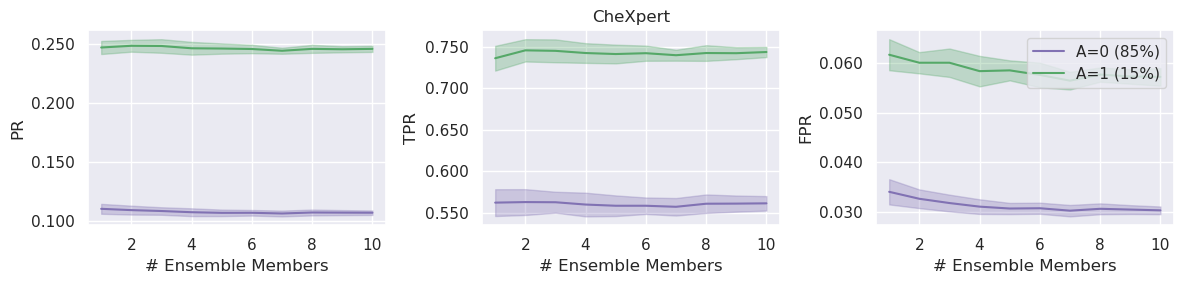

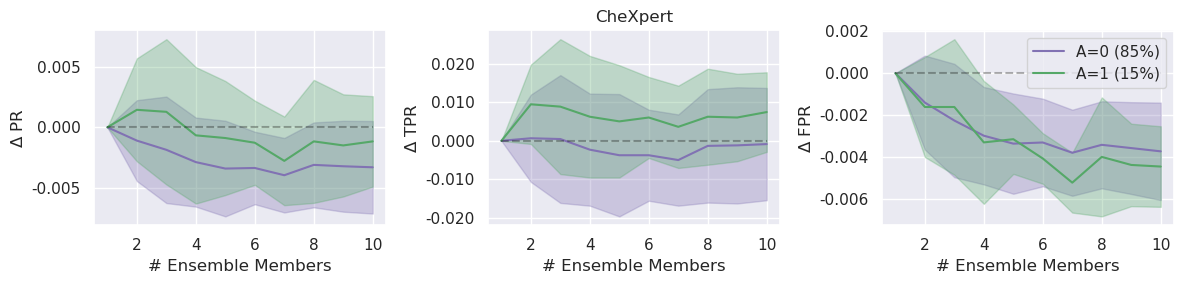

In [11]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

for delta in [False, True]:

    fair_fm_prs_1, fair_fm_prs_0 = list(), list()
    fair_fm_tprs_1, fair_fm_tprs_0 = list(), list()
    fair_fm_fprs_1, fair_fm_fprs_0 = list(), list()
    

    for m in range(len(method_seeds)):

        fair_fm_prs_1_, fair_fm_prs_0_ = list(), list()
        fair_fm_tprs_1_, fair_fm_tprs_0_ = list(), list()
        fair_fm_fprs_1_, fair_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(fair_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_fair_t)
            tpr1, tpr0 = get_tprs(preds, y_fair_t, a_fair_t)
            fpr1, fpr0 = get_fprs(preds, y_fair_t, a_fair_t)
            fair_fm_prs_1_.append(pr1)
            fair_fm_prs_0_.append(pr0)
            fair_fm_tprs_1_.append(tpr1)
            fair_fm_tprs_0_.append(tpr0)
            fair_fm_fprs_1_.append(fpr1)
            fair_fm_fprs_0_.append(fpr0)
            
        if delta:
            fair_fm_prs_1.append([t - fair_fm_prs_1_[0] for t in fair_fm_prs_1_])
            fair_fm_prs_0.append([t - fair_fm_prs_0_[0] for t in fair_fm_prs_0_])
            fair_fm_tprs_1.append([t - fair_fm_tprs_1_[0] for t in fair_fm_tprs_1_])
            fair_fm_tprs_0.append([t - fair_fm_tprs_0_[0] for t in fair_fm_tprs_0_])
            fair_fm_fprs_1.append([t - fair_fm_fprs_1_[0] for t in fair_fm_fprs_1_])
            fair_fm_fprs_0.append([t - fair_fm_fprs_0_[0] for t in fair_fm_fprs_0_])

        else:
            fair_fm_prs_1.append(fair_fm_prs_1_)
            fair_fm_prs_0.append(fair_fm_prs_0_)
            fair_fm_tprs_1.append(fair_fm_tprs_1_)
            fair_fm_tprs_0.append(fair_fm_tprs_0_)
            fair_fm_fprs_1.append(fair_fm_fprs_1_)
            fair_fm_fprs_0.append(fair_fm_fprs_0_)

    fair_fm_prs_1 = np.asarray(fair_fm_prs_1)
    fair_fm_prs_0 = np.asarray(fair_fm_prs_0)
    fair_fm_tprs_1 = np.asarray(fair_fm_tprs_1)
    fair_fm_tprs_0 = np.asarray(fair_fm_tprs_0)
    fair_fm_fprs_1 = np.asarray(fair_fm_fprs_1)
    fair_fm_fprs_0 = np.asarray(fair_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([fair_fm_prs_0, fair_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ PR" if delta else "PR")
    for t, test_pr in enumerate([fair_fm_tprs_0, fair_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[1].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ TPR" if delta else "TPR")
    for t, test_pr in enumerate([fair_fm_fprs_0, fair_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[2].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ FPR" if delta else "FPR")
    axs[2].legend(loc="upper right")

    axs[1].set_title("CheXpert")

    for ax in axs:
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_delta_rates.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_rates.pdf"))
    plt.show()

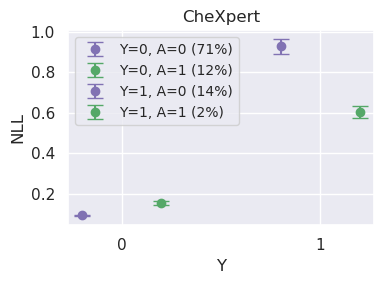

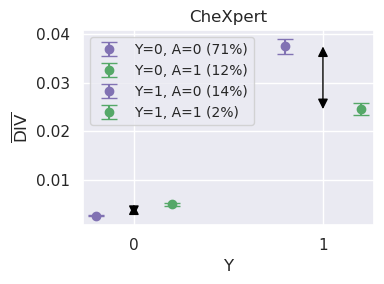

In [12]:
fair_member_loss_y0_a1, fair_member_loss_y1_a1, fair_member_loss_y0_a0, fair_member_loss_y1_a0 = list(), list(), list(), list()
fair_member_loss_a1, fair_member_loss_a0 = list(), list()
fair_ensemble_loss_y0_a1, fair_ensemble_loss_y1_a1, fair_ensemble_loss_y0_a0, fair_ensemble_loss_y1_a0 = list(), list(), list(), list()
fair_ensemble_loss_a1, fair_ensemble_loss_a0 = list(), list()

preds = torch.stack(fair_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_fair_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

fair_member_loss_y1_a1 = member_loss[..., (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=2).reshape(1, -1)
fair_member_loss_y0_a1 = member_loss[..., (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=2).reshape(1, -1)
fair_member_loss_y1_a0 = member_loss[..., (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=2).reshape(1, -1)
fair_member_loss_y0_a0 = member_loss[..., (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=2).reshape(1, -1)
fair_member_loss_a1 = member_loss[..., a_fair_t == 1].mean(dim=2).reshape(1, -1)
fair_member_loss_a0 = member_loss[..., a_fair_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2, 
#                                          index=y_fair_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                         index=y_fair_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]
fair_ensemble_loss_y1_a1 = ensemble_loss[..., (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y0_a1 = ensemble_loss[..., (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y1_a0 = ensemble_loss[..., (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y0_a0 = ensemble_loss[..., (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_a1 = ensemble_loss[..., a_fair_t == 1].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_a0 = ensemble_loss[..., a_fair_t == 0].mean(dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([fair_member_loss_y0_a0, fair_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
for t, test_ent in enumerate([fair_member_loss_y1_a0, fair_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
# for t, test_ent in enumerate([fair_ensemble_loss_y0_a0, fair_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([fair_ensemble_loss_y1_a0, fair_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("CheXpert")
plt.ylabel("NLL")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.legend(fontsize="small")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood.pdf"))
plt.show()


# YA difference
fair_member_loss_y0_a0 = torch.mean(fair_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y0_a1 = torch.mean(fair_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y1_a0 = torch.mean(fair_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y1_a1 = torch.mean(fair_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

test_ents_y0 = [fair_member_loss_y0_a0 - fair_ensemble_loss_y0_a0, fair_member_loss_y0_a1 - fair_ensemble_loss_y0_a1]
for t, test_ent in enumerate(test_ents_y0):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
test_ents_y1 = [fair_member_loss_y1_a0 - fair_ensemble_loss_y1_a0, fair_member_loss_y1_a1 - fair_ensemble_loss_y1_a1]
for t, test_ent in enumerate(test_ents_y1):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
ylims = plt.gca().get_ylim()
arrow = patches.FancyArrowPatch((0, torch.mean(test_ents_y0[1][0], dim=0)), 
                                (0, torch.mean(test_ents_y0[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
arrow = patches.FancyArrowPatch((1, torch.mean(test_ents_y1[1][0], dim=0)), 
                                (1, torch.mean(test_ents_y1[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
plt.ylim(ylims)
plt.title("CheXpert")
plt.ylabel("$\\overline{\mathrm{DIV}}$")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.legend(fontsize="small")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood_ratio.pdf"))
plt.show()

In [14]:
print("#" * 80)
print(f"CheXpert Test Set | Protected Attribute: {pas[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"AUROC: Mean = {np.mean(np.asarray(fair_aurocs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(fair_aurocs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(fair_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(fair_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(fair_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"AUROC: Mean = {np.mean(np.asarray(fair_aurocs) * 100):.2f}, Std = {np.std(np.asarray(fair_aurocs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(fair_spds):.4f}, Std = {np.std(fair_spds):.4f}")
print(f"EOD: Mean = {np.mean(fair_eods):.4f}, Std = {np.std(fair_eods):.4f}")
print(f"AOD: Mean = {np.mean(fair_aods):.4f}, Std = {np.std(fair_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_auroc_spd = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (AUROC): Mean = {np.mean(fairest_auroc_spd * 100):.2f}, Std = {np.std(fairest_auroc_spd * 100):.2f}")
fairest_spds = np.asarray(fair_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_auroc_eod = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_auroc_eod * 100):.2f}, Std = {np.std(fairest_auroc_eod * 100):.2f}")
fairest_eods = np.asarray(fair_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_auroc_aod = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_auroc_aod * 100):.2f}, Std = {np.std(fairest_auroc_aod * 100):.2f}")
fairest_aods = np.asarray(fair_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(fair_m_aurocs) * 100):.2f}, Std = {np.std(np.asarray(fair_m_aurocs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(fair_m_spds):.4f}, Std = {np.std(fair_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(fair_m_eods):.4f}, Std = {np.std(fair_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(fair_m_aods):.4f}, Std = {np.std(fair_m_aods):.4f}")
print("-" * 80)

################################################################################
CheXpert Test Set | Protected Attribute: young
################################################################################
Individual Models:
AUROC: Mean = 94.04, Std = 0.10
SPD: Mean = 0.1369, Std = 0.0026
EOD: Mean = 0.1736, Std = 0.0060
AOD: Mean = 0.1006, Std = 0.0040
--------------------------------------------------------------------------------
Individual Models (all):
AUROC: Mean = 93.99, Std = 0.15
SPD: Mean = 0.1377, Std = 0.0037
EOD: Mean = 0.1741, Std = 0.0101
AOD: Mean = 0.1014, Std = 0.0056
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Accuracy (AUROC): Mean = 94.00, Std = 0.14
SPD: Mean = 0.1372, Std = 0.0036
Accuracy (EOD): Mean = 94.01, Std = 0.12
EOD: Mean = 0.1688, Std = 0.0111
Accuracy (AOD): Mean = 94.02, Std = 0.13
AOD: Mean = 0.0999, Std = 0.0063
------------------------------------------------------------